In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd

global N_total
N_total = 100
alpha_damage_propagation = 0.062
coupling_factor = 0.089
mortality_rate = 4.3*(10**(-5))
disease_rate = 0.02

#@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total**2))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1

        else: 
            died = True

        t+=τ
    return np.array([t,N, died]) 

#@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):

    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
        if X[i][2]:
            break
    return X

x0 = np.array([0., 0., False])

num_cel = 1000 #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,10000.,2.)) for i in tqdm(range(num_cel))])

100%|██████████| 1000/1000 [00:14<00:00, 70.87it/s]


In [59]:
celulas[0][:,1]

array([0., 1., 1., ..., 0., 0., 0.])

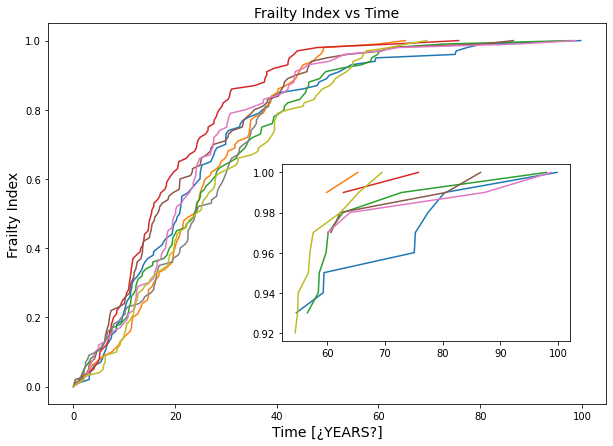

In [138]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
zoom_region = [0.45, 0.25, 0.4, 0.35]

fig, ax = plt.subplots(figsize = (10,7))
ax_zoom = plt.axes(zoom_region)
for i in range(1,10):
    indice = np.argmax(celulas[i][:, 2] == 1)
    ax.plot(celulas[i][:indice][:,0]/100, celulas[i][:indice][:,1]/100)
    ax_zoom.plot(celulas[i][2700:indice][:,0]/100, celulas[i][2700:indice][:,1]/100)
ax.set_xlabel("Time [¿YEARS?]", fontsize = 14)
ax.set_ylabel("Frailty Index", fontsize = 14)
ax.set_title("Frailty Index vs Time", fontsize = 14)
plt.savefig("Gillespie_patterns.jpg", dpi = 500)
plt.show()


# Estadisticas